# Selecting models for text classification

Yesterday we learned the basics of training supervised machine learning models for text classification. Today we will learn how to evaluate models and select the best one for a specific case. This involves training more models and learning different and better ways to estimate their performance.

## Learning Goals
* 

## Outline

* [X](#intro)
    * [X](#example)
    * [X](#basics)
* [Load and inspect dataset](#dataset)
    * [Import modules](#import)
    * [Read and inspect data](#dataset)
    * [Preprocess data](#preprocess)
    * [Vectorization](#vectorize)
    * [Divide data into training and test sets](#split)
* [X](#supervised)
    * [X](#model)
    * [X](#prediction)
    * [Cross-validation](#cv)
    * [X](#features)
    
## Key Terms

* *overfitting* :
    * When a model is trained on too little data to generalize to new data, usually when trained and tested on the same sample. In this case, the model just repeats the labels of the samples that it has just seen, and is evaluated to have a perfect score--but it fails to predict anything useful on yet-unseen data.
* *cross-validation*:
    * A way to assess the performance of an algorithm on an unseen data set. Essentially this repeats a train-test split several times and averages the result of these independent slices, giving a superior estimation of model accuracy compared to a single train-test split

# Data preparation<a id='preparation'></a>

## Import modules<a id='import'></a>

In [9]:
import os
import re
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#scikit-learn is a huge library. We import what we need.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble

## Read and inspect dataset<a id='dataset'></a>

The dataset was collected by [Crowdflower](https://www.crowdflower.com/), which they then made public through [Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). Note that this is a nice clean dataset--not the norm in real-life data science, but it lets us focus on text classification rather than preprocessing.

In [3]:
df = pd.read_csv('tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Which airlines are tweeted about and how many of each in this dataset?

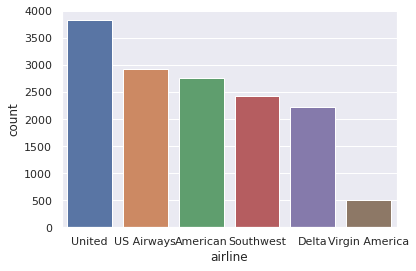

In [4]:
sns.countplot(df['airline'], order=df['airline'].value_counts().index)

### Challenge

- How many tweets are in the dataset?
- How many tweets are positive, neutral and negative?
- What **proportion** of tweets are positive, neutral and negative?
- Visualize these last two questions.

In [5]:
# solution
print("Length is", len(df))

df['airline_sentiment'].value_counts()

Length is 14640


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [6]:
df['airline_sentiment'].value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

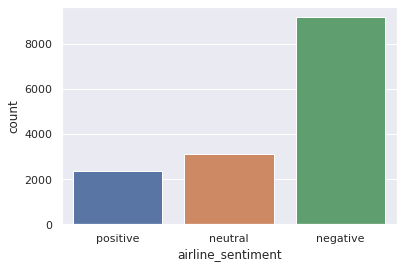

In [7]:
sns.countplot(df['airline_sentiment'], order=['positive', 'neutral', 'negative'])

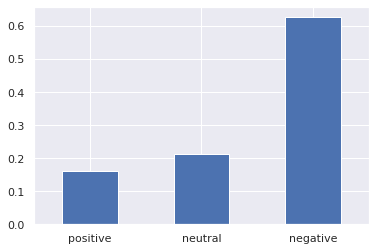

In [10]:
df['airline_sentiment'].value_counts(normalize=True, ascending=True).plot(kind='bar', rot=0)

### Extra challenges

- When did the tweets come from?
- Who gets more retweets: positive, negative or neutral tweets?
- What are the three main reasons why people are tweeting negatively? What could airline companies do to improve this?
- What's the distribution of time zones in which people are tweeting?
- Is this distribution consistent depending on what airlines they're tweeting about?

**All the tweets in this dataset came from the third week of February 2015.**

In [11]:
# solution
dates = pd.to_datetime(df['tweet_created'])
print("Year:\n")
print(dates.dt.year.value_counts())
print("Month:\n")
print(dates.dt.month.value_counts())
print("Day:\n")
print(dates.dt.day.value_counts())

Year:

2015    14640
Name: tweet_created, dtype: int64
Month:

2    14640
Name: tweet_created, dtype: int64
Day:

22    3079
23    3028
21    1557
20    1500
17    1408
19    1376
18    1344
24    1344
16       4
Name: tweet_created, dtype: int64


We don't see any interesting evidence of tweets of different classes getting more or less retweets. The vast majority of tweets from all three classes get no retweets.

In [12]:
df.groupby('airline_sentiment')['retweet_count'].describe()

,count,mean,std,min,25%,50%,75%,max
airline_sentiment,,,,,,,,
negative,9178.0,0.093375,0.792865,0.0,0.0,0.0,0.0,44.0
neutral,3099.0,0.060987,0.658037,0.0,0.0,0.0,0.0,28.0
positive,2363.0,0.069403,0.659914,0.0,0.0,0.0,0.0,22.0


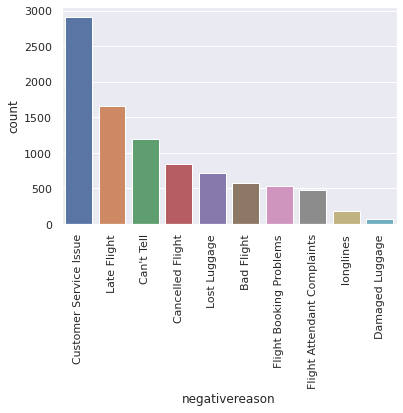

In [13]:
sns.countplot(df['negativereason'], order=df['negativereason'].value_counts().index)
plt.xticks(rotation=90);

## Preprocess data<a id='preprocess'></a>

How are we going to turn our tweets into numbers? First, let's do some quick preprocessing to remove junk.

In [14]:
twitter_handle_pattern = r'@(\w+)'
hashtag_pattern = r'(?:^|\s)[＃#]{1}(\w+)'
url_pattern = r'https?:\/\/.*.com'

def clean_tweets(tweets):
    tweets = [re.sub(hashtag_pattern, ' HASHTAG', t) for t in tweets]
    tweets = [re.sub(twitter_handle_pattern, 'USER', t) for t in tweets]
    return [re.sub(url_pattern, 'URL', t) for t in tweets]

my_tweets = ["lol @justinbeiber and @BillGates are like soo #yesterday #amiright saw it on https://twitter.com #yolo",
            'omg I am never flying on Delta again',
            'I love @VirginAmerica so much #friendlystaff']

clean_tweets(my_tweets)

['lol USER and USER are like soo HASHTAG HASHTAG saw it on URL HASHTAG',
 'omg I am never flying on Delta again',
 'I love USER so much HASHTAG']

In [15]:
df['clean_text'] = (df['text']
                    .str.replace(hashtag_pattern, 'HASHTAG')
                    .str.replace(twitter_handle_pattern, 'USER')
                    .str.replace(url_pattern, 'URL')
                              )
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),USER What USER said.
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),USER plus you've added commercials to the expe...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),USER I didn't today... Must mean I need to tak...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),USER it's really aggressive to blast obnoxious...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),USER and it's a really big bad thing about it


## Vectorization<a id='vectorization'></a>

Now that we've cleaned the text, we turn the text into numbers for our classifier. As we did yesterday, we will use `scikit-learn`'s `CountVectorizer` and a "bag of words" approach to create our features: frequency counts of all the words that appear in a text. 

In [16]:
countvectorizer = CountVectorizer(max_features=5000, binary=True)
X = countvectorizer.fit_transform(df['clean_text'])
features = X.toarray()
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [30]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [17]:
response = df['airline_sentiment'].values
response

array(['neutral', 'positive', 'neutral', ..., 'neutral', 'negative',
       'neutral'], dtype=object)

## Divide data into training and test sets<a id='split'></a>

As we did yesterday, let's split our data into training and test sets. _Unlike_ yesterday, we will use a shortcut to create this split: the useful `train_test_split()` function from `scikit-learn`. We will also balance the outcome variable (sentiment) between our training and test samples. 

We'll train on 80% of the data and test the model's accuracy on the rest. An 80/20 split is typical in machine learning tasks; according to the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle), this ratio allows for efficiency and occurs in nature as well as in business, computing, and economics. 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2)

X_train.shape, X_test.shape #look at number of rows and columns in training and test data

((11712, 5000), (2928, 5000))

Now that we've split our data up into `train` and `test` sets, let's look to see how the output variable is distributed within the two datasets.

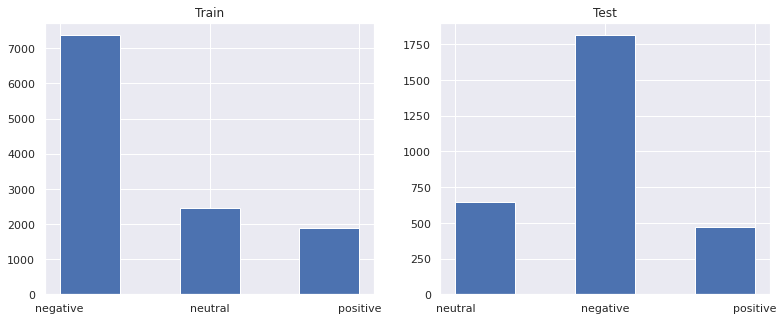

In [25]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist(y_train, bins=5)
plt.title('Train')
plt.subplot(1,2,2)
plt.hist(y_test, bins=5);
plt.title('Test');

## Balance categories of dependent variable<a id='balance'></a>

The three possible values of the output variable (sentiment) are not equally distributed. This can cause a problem for model performance. Fortunately we can tell `sklearn` to split them equally using the `stratify` parameter as follows:

### TO DO: Fix this part, move below?

In [26]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.20, stratify=response)

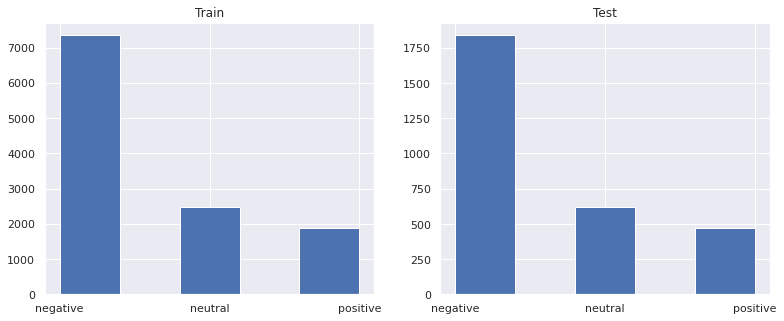

In [27]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist(y_train, bins=5)
plt.title('Train')
plt.subplot(1,2,2)
plt.hist(y_test, bins=5);
plt.title('Test');

That's much better, they are all equal now!

In [ ]:
#let's try a different classifier, LinearSVC
svc = LinearSVC()
svc.fit(training_dtm_tf, training_labels)
predictions_svc = svc.predict(test_dtm_tf) 
accuracy_score(predictions_svc, test_labels)

In [ ]:
#k nearest neighbor
knn = KNeighborsClassifier()
knn.fit(training_dtm_tf, training_labels)
predictions_knn = knn.predict(test_dtm_tf) 
accuracy_score(predictions_knn, test_labels)

## 2) Decision Trees

The first model we're going to explore is [Decision Trees: Classification](http://scikit-learn.org/stable/modules/tree.html#classification).

After the train/test split, scikit-learn makes the rest of the process relatively easy, since it already has a DT classifier algorith for us, we just have to decide on the parameters:

In [ ]:
from sklearn import tree

dt_classifier = tree.DecisionTreeClassifier(criterion='gini',  # or 'entropy' for information gain
                       splitter='best',  # or 'random' for random best split
                       max_depth=None,  # how deep tree nodes can go
                       min_samples_split=2,  # samples needed to split node
                       min_samples_leaf=1,  # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features=None,  # number of features to look for when splitting
                       max_leaf_nodes=None,  # max nodes
                       min_impurity_decrease=1e-07, #early stopping
                       random_state = 10) #random seed

Then we use the `fit` method on the train data to fit our model. The syntax is a little strange at first, but it's powerful. All the functions for fitting data, making predictions, and storing parameters are encapsulated in a single model object. 

In [ ]:
dt_classifier.fit(X_train, y_train);

To see how our model performs on the test data, we use the `score` method which returns the mean accuracy. Accuracy can be defined as:

$$ Accuracy= $\frac{\sum{\text{True Positives}}+\sum{\text{True Negatives}}}{\sum{\text{Total Population}}}$$

Where "True Positives" are those data points whose value should be 1, and they are predicted to be 1, and "True Negatives" are those data points whose values should be -1 (or 0), and they are predicted to be -1 (or 0).

`score` can be used on both the train and test datasets. Using the train data will give us the in-sample accurac score.

In [ ]:
print(dt_classifier.score(X_train, y_train))

That's a perfect score of `1.0`! But the model may be overfit to the train data, so we should evaluate the performance of this model using the test data.

In [ ]:
print(dt_classifier.score(X_test, y_test))

Not quite perfect, but still really good!

We can get the feature importance (Gini importance) of the four features to see which one(s) are important in determining the classification:

In [ ]:
dt_classifier.feature_importances_

Looks like the fourth variable is most important, with a Gini importance score of ~`0.94`. Let's find out which feature that is.

In [ ]:
iris.feature_names[dt_classifier.feature_importances_.argmax()]

There are  metrics other than accuracy to quantify classification performance. Some common metrics in machine learning are:

1. **Precision**: 
$$\frac{\sum{\text{Predicted Positives}}}{\sum{\text{True Positives}}}$$
2. **Recall** (or **Sensitivity**): 
$$\frac{\sum{\text{Predicted Positives}}}{\sum{\text{Condition Positives}}}$$ 
3. **Specificity** (like recall for negative examples): 
$$\frac{\sum{\text{Predicted Negatives}}}{\sum{\text{Condition Negatives}}}$$


Below is a table showing how these metrics fit in with other confusion matrix concepts like "True Positives" and "True Negatives" [wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix)

<img src='https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg' width=300>/

Scikit-learn will can print out the **Recall** and **Precision** scores for a classification model by using `metrics.classification_report()`.

In [ ]:
from sklearn import metrics

dt_predicted = dt_classifier.predict(X_test)
print("Classification report:")
print(metrics.classification_report(y_test, dt_predicted)) 

## 3) Tuning Parameters: Cross-Validation & Grid Search

Tuning parameters is one of the most important steps in building a ML model. One way to do this is by using what's called a [grid search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). A grid search tests different possible parameter combinations to see which combination yields the best results. Fortunately, scikit-learn has a function for this which makes it very easy to do.

Here we'll see what the best combination of the parameters `min_samples_split` and `min_samples_leaf` is. We can make a dictionary with the names of the parameters as the keys and the range of values as the corresponding values.

In [ ]:
param_grid = {'min_samples_split': range(2,10),
              'min_samples_leaf': range(1,10)}

param_grid

Then we can implement the grid search and fit our model according to the best parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

model_dt = GridSearchCV(dt_classifier, param_grid, cv=3, iid=False, return_train_score=True)
model_dt.fit(X_train, y_train);

We can see what the model parameters are that produce the highest accuracy on the test set data by finding the max `mean_test_score`, and it's assoiated parameter values:

In [ ]:
best_index = np.argmax(model_dt.cv_results_["mean_test_score"])

print('Best parameter values are:', model_dt.cv_results_["params"][best_index])
print('Best Mean Cross-Validation train accuracy: %.03f' % (model_dt.cv_results_["mean_train_score"][best_index]))
print('Best Mean Cross-Validation test (validation) accuracy: %.03f' % (model_dt.cv_results_["mean_test_score"][best_index]))
print('Overal mean test accuracy: %.03f' % (model_dt.score(X_test, y_test)))

We can also look at all of the combinations and their test and train scores:

In [ ]:
#model_dt

In [ ]:
n_grid_points = len(model_dt.cv_results_['params'])
min_samples_leaf_vals = np.empty((n_grid_points,))
min_samples_split_vals = np.empty((n_grid_points,))
mean_train_scores = np.empty((n_grid_points,))
mean_test_scores = np.empty((n_grid_points,))
for i in range(n_grid_points):
    min_samples_leaf_vals[i] = model_dt.cv_results_['params'][i]['min_samples_leaf']
    min_samples_split_vals[i] = model_dt.cv_results_['params'][i]['min_samples_split']
    mean_train_scores[i] = model_dt.cv_results_['mean_train_score'][i]
    mean_test_scores[i] = model_dt.cv_results_['mean_test_score'][i]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf( min_samples_leaf_vals, min_samples_split_vals, mean_train_scores, cmap=cm.coolwarm,
                       linewidth=10, antialiased=False)
ax.set_title('Mean Train Scores', fontsize=18)
ax.set_xlabel('min_samples_leaf', fontsize=18)
ax.set_ylabel('min_samples_split', fontsize=18)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf( min_samples_leaf_vals, min_samples_split_vals, mean_test_scores, cmap=cm.coolwarm,
                       linewidth=10, antialiased=False)
ax.set_title('Mean Test Scores', fontsize=18)
ax.set_xlabel('min_samples_leaf', fontsize=18)
ax.set_ylabel('min_samples_split', fontsize=18)

## 4) Random Forests

Now we'll look at [Random Forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

- random forests are an ensemble method (the classification decision is pooled across many simpler classifiers)
- each decision tree is fit to a subset of the data (bagging), and uses only a subset of the features (random subspace). 

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import ensemble

rf_classifier = ensemble.RandomForestClassifier(n_estimators=10,  # number of trees
                       criterion='gini',  # or 'entropy' for information gain
                       max_depth=None,  # how deep tree nodes can go
                       min_samples_split=2,  # samples needed to split node
                       min_samples_leaf=1,  # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features='auto',  # number of features for best split
                       max_leaf_nodes=None,  # max nodes
                       min_impurity_decrease=1e-07,  # early stopping
                       n_jobs=1,  # CPUs to use
                       random_state = 10,  # random seed
                       class_weight="balanced")  # adjusts weights inverse of freq, also "balanced_subsample" or None

Now we fit the model on our training data.

In [ ]:
rf_model = rf_classifier.fit(X_train, y_train)

Let's look at the classification performance on the test data:

In [ ]:
print("Score of model with test data defined above:")
print(rf_model.score(X_test, y_test))
print()

predicted = rf_model.predict(X_test)
print("Classification report:")
print(metrics.classification_report(y_test, predicted)) 
print()

Let's do another grid search to determine the best parameters:

In [ ]:
param_grid = {'min_samples_split': range(2,10),
              'min_samples_leaf': range(1,10)}

model_rf = GridSearchCV(ensemble.RandomForestClassifier(n_estimators=10), param_grid, cv=3, iid=False)
model_rf.fit(X_train, y_train)

best_index = np.argmax(model_rf.cv_results_["mean_test_score"])

print("Best parameter values:", model_rf.cv_results_["params"][best_index])
print("Best Mean cross-validated test accuracy:", model_rf.cv_results_["mean_test_score"][best_index])
print("Overall Mean test accuracy:", model_rf.score(X_test, y_test))

## 5) Predict

Great! That's quite accurate. So let's say we're walking through a garden and spot an iris, but have no idea what type it is. We take some measurements:

In [ ]:
random_iris = [5.1, 3.5, 2, .1]

for i in range(len(random_iris)):
    print(iris.feature_names[i])
    print(random_iris[i])
    print()

Can we use our model to predict the type?

In [ ]:
label_idx = model_rf.predict([random_iris])
label_idx

Now we can just index our labels:

In [ ]:
iris.target_names[label_idx]

# Challenge: AdaBoost

Adaboost is another ensemble method that relies on 'boosting'. Similar to 'bagging', 'boosting' samples many subsets of data to fit multiple classifiers, but resamples preferentially for mis-classified data points. 

### Part 1

Using the scikit-learn [documentation](http://scikit-learn.org/stable/modules/ensemble.html#adaboost), build your own AdaBoost model to test on the iris data set! Start off with `n_estimators` at 100, and `learning_rate` at .5. Use 10 as the `random_state` value.

### Part 2

Now use a grid search to determine what the best values for the `n_estimators` and `learning_rate` parameters are. For `n_estimators` try a range of 50 to 500 with a step of 50, and for `learning_rate` try a range of .1 to 1.1 with a step of .1. For decimal steps in a range use the `np.arange` function.